In [1]:
# numerical / scientific
import numpy as np
import torch
import gpytorch as gp

# data
import pandas as pd
import pandas_datareader.data as web
import yfinance as yf

# plotting
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 5)

# misc
import datetime
from typing import Tuple
from tqdm import tqdm

# utility  imports
from utilities.processing_utility import get_q_2_cw_data, get_train_test_split
from utilities.plotting_utility import plot_daily, plot_price_and_returns
from utilities.strategy_utilities import get_theta_and_V, get_turnover_dollars, get_turnover_units
from utilities.performance_utilities import *

# strategies imports
import strategies.gp_mean_reversion as gp_mean_reversion
from strategies.gp_mean_reversion import get_gp_mean_reversion_signal
import strategies.gp_prediction as gp_prediction
from strategies.gp_prediction import get_augmented_data, get_gp_prediction_signal


In [9]:
class ConstantGP(gp.models.ExactGP):
    """  GP with Linear Mean """
    
    def __init__(self, inputs, targets, likelihood):
        super(ConstantGP, self).__init__(inputs, targets, likelihood)
        self.mean_module = gp.means.constant_mean.ConstantMean()
        self.covar_module = gp.kernels.ScaleKernel(gp.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gp.distributions.MultivariateNormal(mean_x, covar_x)
    
    def get_posterior(self, test_inputs, confidenceregion = False):
        self.eval()
        with torch.no_grad(), gp.settings.fast_pred_var():
            f_preds = self(test_inputs)

        if confidenceregion:
            lower, upper = f_preds.confidence_region()
            return f_preds, lower, upper
        
        return f_preds

    def get_posterior_predictive(self, test_inputs, confidenceregion = False):
        # get posterior
        self.eval()
        with torch.no_grad(), gp.settings.fast_pred_var():
            observed_pred = self.likelihood(self(test_inputs))

        if confidenceregion:
            lower, upper = observed_pred.confidence_region()
            return observed_pred, lower, upper
        
        return observed_pred

In [20]:
def get_gp_prediction_signal(
    X : torch.Tensor,
    P : torch.Tensor,
    lengthscale : float = 2.5,
    noise : float = .5,
    window : int = 20,
    ) -> torch.Tensor:
    """
    Get the signal for a GP cross over strategy.

    Arguments:
    ----------
    X           : {torch.Tensor}
                    > The time series of the data.
    P           : {torch.Tensor}
                    > The time series of the prices.

    Returns:
    ----------
    signal      : {torch.Tensor}
                    > The signal for the GP cross over strategy.
    buy_mask    : {torch.Tensor}
                    > The mask for the buy signal.
    sell_mask   : {torch.Tensor}
    """
    # setp
    buy_mask = torch.zeros_like(P)
    sell_mask = torch.zeros_like(P)

    signal = torch.zeros_like(P)   

    rolling_std = P.unfold(0, window, 1).std(dim=1)
    signal_weights = (rolling_std / rolling_std.max())*0.98

    # sequential prediction
    for i, (x, p) in enumerate(zip(X, P)):     
        
        if i <= window:
            signal[i] = 0
            continue

        # fit a GP to ths historica data
        n_start = i - window
        n_end = i 
        window_gp = ConstantGP(X[n_start:n_end], P[n_start:n_end], gp.likelihoods.GaussianLikelihood())

        weights = torch.pow(1 - 0.5, torch.arange(len(P[n_start:n_end])).float())
        weights /= torch.sum(weights)

        window_gp.mean_module.constant = torch.sum(weights * P[n_start:n_end])
        # torch.mean(P[n_start:n_end])
        window_gp.covar_module.base_kernel.lengthscale = lengthscale
        window_gp.likelihood.noise = noise

        if i + 1 < len(X):
            f_test, upper, lower = window_gp.get_posterior_predictive(X[n_end+1].view(1,-1), True)
            f_test = f_test.mean.item()

        if (upper > p) and (p > lower):
            signal[i] = 0.5

        elif (f_test > p) and (p > upper):
            buy_mask[i] = 1
            signal[i] = signal_weights[i-window]

        elif (f_test < p) and (p < lower):
            sell_mask[1] = 1
            signal[i] = -signal_weights[i-window]

        else:
            signal[i] = 0

    return signal, buy_mask, sell_mask

In [21]:
df = get_q_2_cw_data()
df.to_csv('cw_2_data.csv')

[*********************100%***********************]  1 of 1 completed


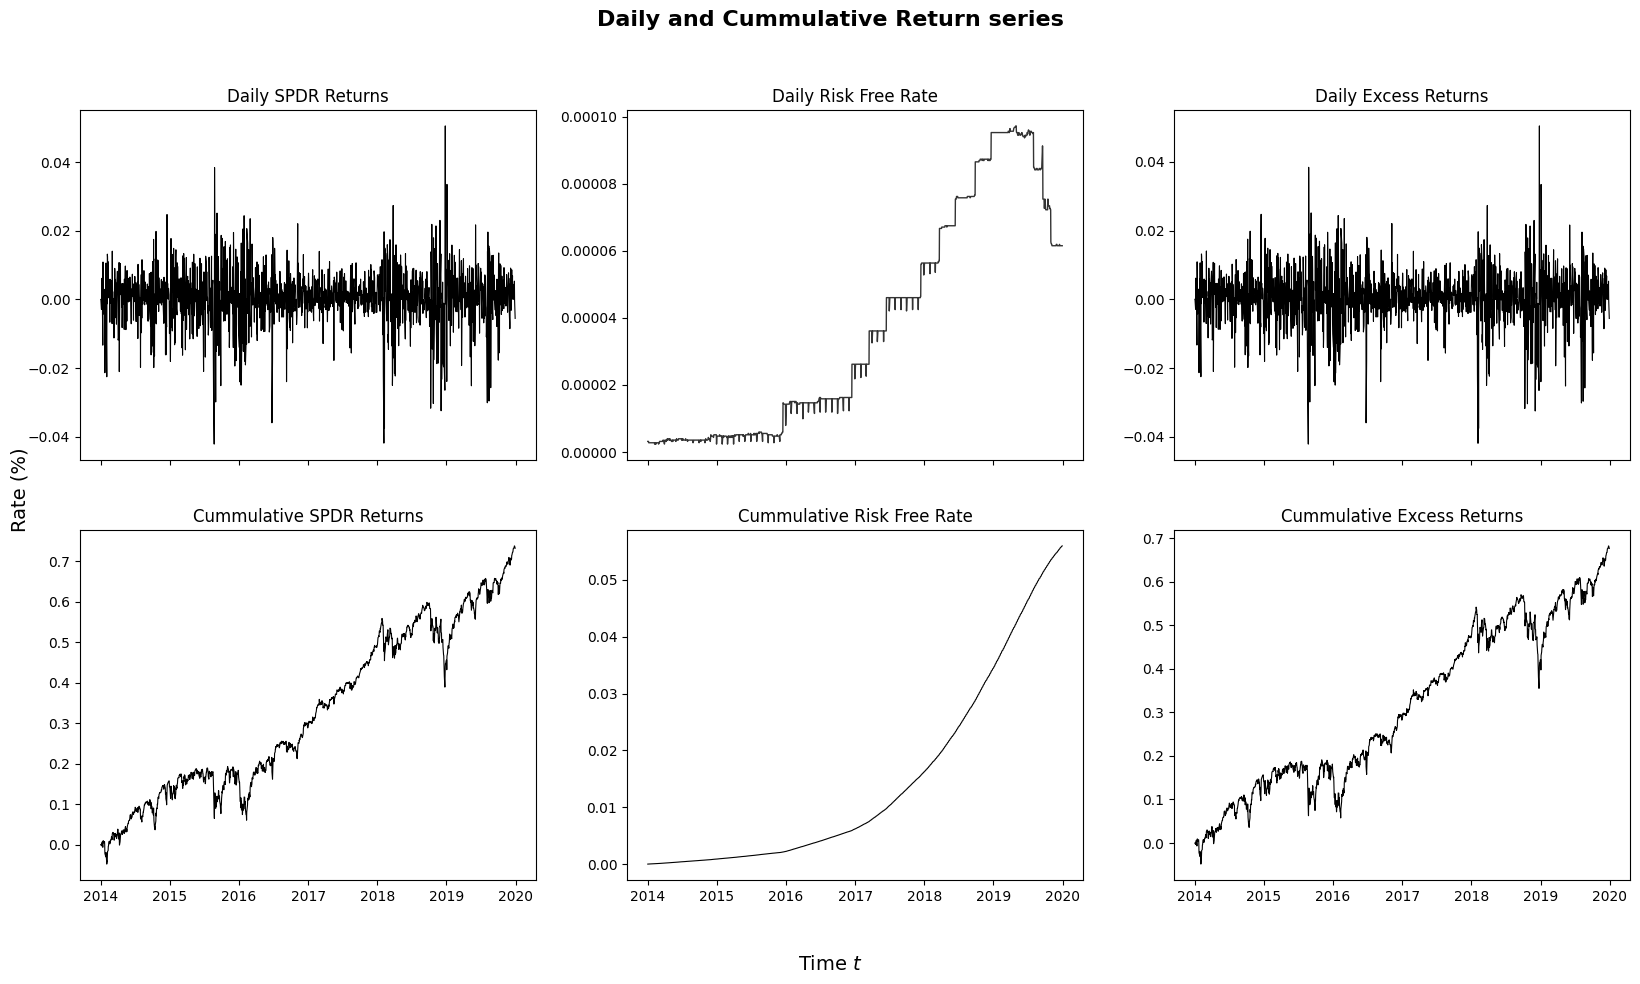

In [22]:
daily_returns_fig = plot_daily(df)

# save figure
daily_returns_fig.savefig('figures/01_daily_returns.png')

In [23]:
# get train test split
split_idx = int(len(df) * 0.7)
risk_free_rate_series = torch.tensor(df['daily_effr'].to_numpy(), dtype=torch.float32)
excess_return_data = torch.tensor(df['daily_excess_returns'].to_numpy(), dtype=torch.float32)
norm_excess_return_data = torch.tensor(df['normalised_excess_returns'].to_numpy(), dtype=torch.float32)
price_data = torch.tensor(df['adjusted_close_price'].to_numpy(), dtype=torch.float32)
x_data = torch.arange(0, len(price_data), dtype=torch.float32)

train_data, test_data = get_train_test_split(splitindex = split_idx, RFR = risk_free_rate_series, daily_R = excess_return_data, norm_R = norm_excess_return_data, P = price_data, X = x_data)

rfr_train, rfr_test = train_data['RFR'], test_data['RFR'] #  risk free rate
daily_r_train, daily_r_test = train_data['daily_R'], test_data['daily_R'] # daily excess returns
norm_r_train, norm_r_test = train_data['norm_R'], test_data['norm_R'] # normalised daily excess returns
p_train, p_test = train_data['P'], test_data['P'] # adjusted closing price
x_train, x_test = train_data['X'], test_data['X'] # x data


In [24]:
# GAUSSIAN PROCESS PREDICTION
train_data = get_augmented_data(x_train, p_train)
test_data = get_augmented_data(x_test, p_test)

In [25]:
# GAUSSIAN PROCESS PREDICTION SIGNAL
train_gp_pred_s, train_gp_pred_bm, train_gp_predo_sm = get_gp_prediction_signal(train_data, p_train, lengthscale=12, noise=5, window=80)
test_gp_pred_s, test_gp_pred_bm, test_gp_pred_sm = get_gp_prediction_signal(x_test, p_test, lengthscale=12, noise=5, window=80)

In [26]:
# GET LONG ONLY V
train_lo_strat = get_theta_and_V(daily_r_train, rfr_train , torch.ones_like(p_train), initial_cash = 200_000., leverage = 5.)
test_lo_strat = get_theta_and_V(daily_r_test, rfr_test , torch.ones_like(p_test), initial_cash = 200_000., leverage = 5.)

# GET PREDICTION - GAUSSIAN PROCESS
train_gp_pred_strat = get_theta_and_V(daily_r_train, rfr_train , train_gp_pred_s, initial_cash = 200_000., leverage = 5.)
test_gp_pred_strat = get_theta_and_V(daily_r_test, rfr_test , test_gp_pred_s, initial_cash = 200_000., leverage = 5.)

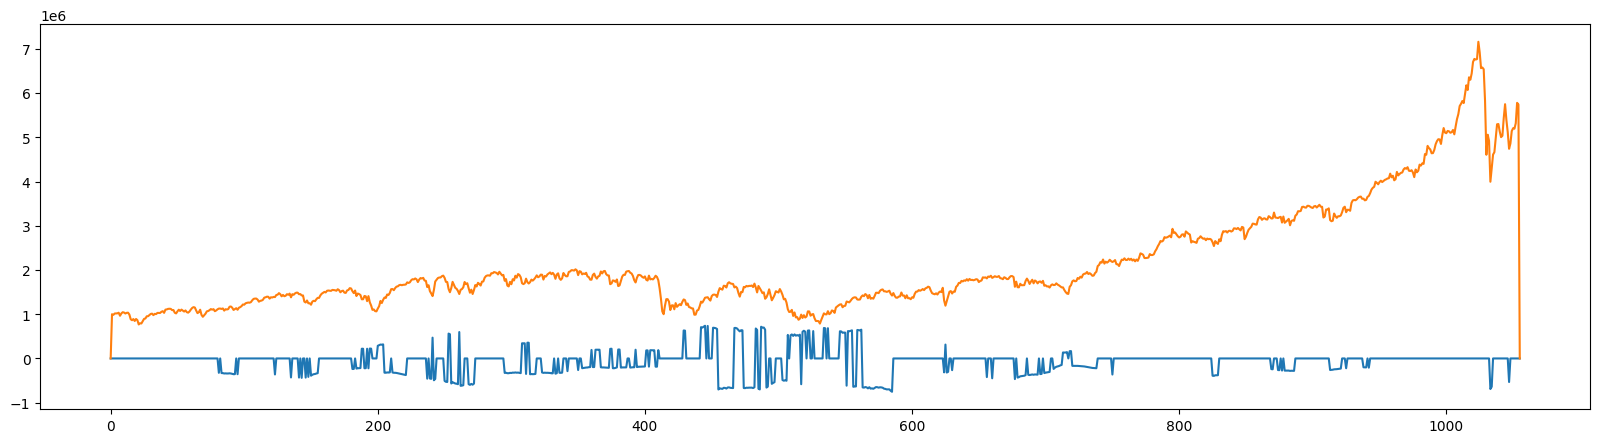

In [27]:
plt.plot(train_gp_pred_strat['theta'], label='GP Prediction')
plt.plot(train_lo_strat['theta'], label='Long Only')